# **Modelling Notebook: Film Success Prediction**



This notebook builds a machine learning classification model to predict whether a film will achieve "High Performer" status based on production attributes, financial metrics, and team composition.

**Aim: Predicting High-Performing Films:**
* Predict film performance using a single classification target (films above or below the median revenue).

### Overview Modelling and Evaluation

**Key Objectives**

* Build a classification model to predict film success (High Performer: Revenue > median)
* Engineer preprocessing pipeline with feature encoding and scaling
* Train Logistic Regression model with cross-validation
* Evaluate model performance and feature importance
* Generate success probability scores and risk level classifications
* Create benchmark comparisons for predicted high-performer films

**Inputs**

* Data/PROCESSED/movies_ready_for_EDA.csv (processed dataset from ETL)
* Features: Budget, Primary_genre, Language_full, Runtime, Primary_production_country, Primary_production_company, Avg_actor_frequency, Has_known_lead, Lead_actor_recurrence_rate, Primary_actor_is_frequent
* Target: Revenue (to create binary High Performer classification)

**Outputs**

* Trained Logistic Regression model with preprocessing pipeline (saved as .pkl)
* Model performance metrics (accuracy, precision, recall, AUC-ROC)
* Feature importance analysis
* Predictions on test set with success probability and risk levels
* Visualisations: Confusion matrix, ROC curve, feature importance
* Summary Insights and performance reports:
    - reports/benchmark_comparison.csv
    - feature_importance.csv
    - model_metrics.csv
    - model_predictions.csv

---


**Additional Comments**

* Language feature heavily skewed to English, converted to binary (English vs Non-English)
* Missing values handled via imputation pipeline
* Categorical features one-hot encoded
* Numeric features standardised for model stability
* Classification preferred over regression for clearer business interpretation

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\HACK_2\\Team1_TMDb_Hackathon_2\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\HACK_2\\Team1_TMDb_Hackathon_2'

---
# Section 1: Setup and Data Loading

**1.1 Library Imports**

Import all necessary libraries for data analysis, preprocessing, model building, and evaluation.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

---

**1.2 Load and Explore Data**

Load the processed dataset and examine its structure, dimensions, and data types.

In [5]:
# Import OS
import os

# Check for file
data_path = "Data/PROCESSED/movies_ready_for_EDA.csv"
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully from {data_path}")
else:
    print(f"File not found at {data_path}")
    print("Available files in Data/PROCESSED/:")
    if os.path.exists("Data/PROCESSED/"):
        print(os.listdir("Data/PROCESSED/"))
    else:
        print("Data/PROCESSED/ directory does not exist")

# Print Dataset shape and info
print(f"\nDataset shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"\nColumn names and types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully from Data/PROCESSED/movies_ready_for_EDA.csv

Dataset shape: (4803, 46)
Rows: 4803, Columns: 46

Column names and types:
Budget                          int64
Genres                         object
Homepage                       object
Id                              int64
Keywords                       object
Original_language              object
Original_title                 object
Overview                       object
Popularity                    float64
Production_companies           object
Production_countries           object
Release_date                   object
Revenue                         int64
Runtime                       float64
Spoken_languages               object
Status                         object
Tagline                        object
Title_x                        object
Vote_average                  float64
Vote_count                      int64
Has_release_date                 bool
Release_year                    int64
Cast           

,Budget,Genres,Homepage,Id,Keywords,Original_language,Original_title,Overview,Popularity,Production_companies,...,Primary_genre,Primary_production_country,Primary_production_company,Actor_list,Primary_actor,Co_starring_actor,Avg_actor_frequency,Has_known_lead,Lead_actor_recurrence_rate,Primary_actor_is_frequent
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Action,United States of America,Ingenious Film Partners,[],Not_listed,Not_listed,0.000000,0,0,0
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Adventure,United States of America,Walt Disney Pictures,[],Not_listed,Not_listed,0.000000,0,0,0
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Action,United Kingdom,Columbia Pictures,[],Not_listed,Not_listed,0.000000,0,0,0
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,Action,United States of America,Legendary Pictures,[],Not_listed,Not_listed,0.000000,0,0,0
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,Action,United States of America,Walt Disney Pictures,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...",Taylor Kitsch,Lynn Collins,3.740741,1,1,0


# Section 2: Data Preparation for Classification Model

**2.1 Create Target Variable**

- Define "High Performer" as Revenue > median revenue
- Create binary target: 1 = High Performer, 0 = Standard/Underperformer
- Handle missing values in Revenue
- Create target variable: High Performer
- High Performer defined as Revenue > median revenue

In [6]:
# Define feature types
median_revenue = df['Revenue'].median()
print(f"Median Revenue: £{median_revenue:,.0f}")
print(f"\nRevenue statistics:")
print(df['Revenue'].describe())

# Create binary target variable
df['High_performer'] = (df['Revenue'] > median_revenue).astype(int)

# Print target variable distribution and class balance
print(f"\nTarget variable distribution:")
print(df['High_performer'].value_counts())
print(f"\nClass balance:")
print(df['High_performer'].value_counts(normalize=True))

# Remove rows with missing Revenue (cannot determine target)
df_model = df.dropna(subset=['Revenue']).copy()
print(f"\nRows with Revenue data: {len(df_model)} (from {len(df)})")

Median Revenue: £19,170,001

Revenue statistics:
count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: Revenue, dtype: float64

Target variable distribution:
High_performer
0    2402
1    2401
Name: count, dtype: int64

Class balance:
High_performer
0    0.500104
1    0.499896
Name: proportion, dtype: float64

Rows with Revenue data: 4803 (from 4803)


**2.2 Feature Selection and Preparation**
- Select relevant features for model
- Create binary Language feature (English vs Non-English)
- Handle missing values appropriately

In [7]:
# Feature selection and preparation
# Select features for model input

features_to_use = [
    'Budget',
    'Runtime',
    'Primary_genre',
    'Language_full',
    'Primary_production_country',
    'Primary_production_company',
    'Avg_actor_frequency',
    'Has_known_lead',
    'Lead_actor_recurrence_rate',
    'Primary_actor_is_frequent'
]

# Create binary Language feature (English vs Non-English)
df_model['Language_binary'] = (df_model['Language_full'] == 'English').astype(int)
print("Language distribution:")
print(f"English films: {(df_model['Language_binary'] == 1).sum()} ({(df_model['Language_binary'] == 1).sum() / len(df_model) * 100:.1f}%)")
print(f"Non-English films: {(df_model['Language_binary'] == 0).sum()} ({(df_model['Language_binary'] == 0).sum() / len(df_model) * 100:.1f}%)")

# Update features list to use binary Language
features_to_use = [
    'Budget',
    'Runtime',
    'Primary_genre',
    'Language_binary',
    'Primary_production_country',
    'Primary_production_company',
    'Avg_actor_frequency',
    'Has_known_lead',
    'Lead_actor_recurrence_rate',
    'Primary_actor_is_frequent'
]

# Identify numeric and categorical features
numeric_features = [
    'Budget',
    'Runtime',
    'Avg_actor_frequency',
    'Has_known_lead',
    'Lead_actor_recurrence_rate',
    'Primary_actor_is_frequent'
]

categorical_features = [
    'Primary_genre',
    'Language_binary',
    'Primary_production_country',
    'Primary_production_company'
]

# Print feature types
print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Check for missing values
print(f"\nMissing values in features:")
print(df_model[features_to_use].isnull().sum())

Language distribution:
English films: 4505 (93.8%)
Non-English films: 298 (6.2%)

Numeric features: ['Budget', 'Runtime', 'Avg_actor_frequency', 'Has_known_lead', 'Lead_actor_recurrence_rate', 'Primary_actor_is_frequent']
Categorical features: ['Primary_genre', 'Language_binary', 'Primary_production_country', 'Primary_production_company']

Missing values in features:
Budget                        0
Runtime                       0
Primary_genre                 0
Language_binary               0
Primary_production_country    0
Primary_production_company    0
Avg_actor_frequency           0
Has_known_lead                0
Lead_actor_recurrence_rate    0
Primary_actor_is_frequent     0
dtype: int64


---

# Section 3: Build Preprocessing Pipeline

**3.1 Pipeline Components**

- Imputation: Handle missing values with mean/most frequent
- Encoding: One-hot encode categorical features
- Scaling: Standardise numeric features
- Model: Logistic Regression classifier

**3.2 Build Preprocessing and Model Pipeline**

- Numeric transformer: SimpleImputer (mean) + StandardScaler
- Categorical transformer: SimpleImputer (most_frequent) + OneHotEncoder
- Combine with ColumnTransformer
- Add Logistic Regression classifier

In [8]:
# Build preprocessing pipeline

# Numeric pipeline: impute missing values, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create full pipeline with model
ml_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Confirm pipeline creation
print("Pipeline created successfully")
print(f"\nPipeline steps:")
for step_name, step in ml_pipeline.steps:
    print(f"  {step_name}: {type(step).__name__}")

Pipeline created successfully

Pipeline steps:
  preprocessor: ColumnTransformer
  classifier: LogisticRegression


---

# Section 4: Train and Evaluate Model

## Overview

Goal: divide the dataset into two stratified subsets for model development, evaluate the Logistic Regression classification pipeline, ensuring including proper data splitting, cross-validation, and  performance evaluation.

##  Approach

The notebook uses an 80/20 split:
- Training set (80%): Used to fit the model and learn patterns
- Test set (20%): Reserved entirely for unbiased performance evaluation

**Train/Test Split Rationale**

Splitting data into training and test sets prevents overfitting and provides honest performance estimates. The model must never see test data during training, otherwise reported metrics would be misleading and the model would likely perform worse on truly new data in production.

This split reserves sufficient data for reliable testing whilst maximising training data to help the model learn robust patterns.

**Stratification Requirement**

The split uses stratification, which maintains the class balance from the original dataset in both train and test sets (key as the original data has roughly equal High Performer and Standard films). Stratification ensures both sets have the same proportions, preventing skewed evaluation if one set happened to contain predominantly one class.

This split reserves sufficient data for reliable testing whilst maximising training data to help the model learn robust patterns.

**Cross-Validation for Robustness**

Five-fold cross-validation further validates model stability. This technique:
- Divides training data into five equal parts (folds)
- Trains five separate models, each using four folds for training and one fold for validation
- Averages results across all five runs to get robust performance estimates
- Reports standard deviation to show consistency across runs

Cross-validation helps identify whether the model performs reliably or whether performance varies dramatically depending on which data subset is used. Low standard deviation indicates consistent, reliable performance.

**Note on 5 fold testing** 5 fold was opted over 3 fold given dataset is moderate size (46MB) and 5 fold being within resource limits to achieve stable estimate

**4.1 Prepare Features and Train/Test Split**

In [9]:
# Prepare X (features) and y (target)
X = df_model[features_to_use].copy()
y = df_model['High_performer'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Feature matrix shape: (4803, 10)
Target variable shape: (4803,)

Training set size: 3842
Test set size: 961

Training set class distribution:
High_performer
1    0.5
0    0.5
Name: proportion, dtype: float64

Test set class distribution:
High_performer
0    0.50052
1    0.49948
Name: proportion, dtype: float64


**4.2 Model Training with Cross-Validation**

- Train Logistic Regression model on training data
- Evaluate using 5-fold cross-validation
- Generate performance metrics (accuracy, precision, recall, ROC-AUC)

In [10]:
# Train the model
print("Training model...")
ml_pipeline.fit(X_train, y_train)
print("Model training complete")

# Cross-validation scores
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    ml_pipeline, X_train, y_train,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

print(f"\nCross-Validation Results (5-fold):")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"Recall: {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")

Training model...
Model training complete


c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown c


Cross-Validation Results (5-fold):
Accuracy: 0.8058 (+/- 0.0050)
Precision: 0.8274 (+/- 0.0079)
Recall: 0.7730 (+/- 0.0130)
ROC-AUC: 0.8881 (+/- 0.0040)


c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**4.3 Test Set Evaluation and Performance Metrics Explanation**

Generate predictions on the test set and calculate comprehensive performance metrics. The metrics reported below provide different perspectives on model performance (the aim is for them to help identify strengths and weaknesses):
- Accuracy represents the overall correctness of predictions across both classes. However, accuracy alone can be misleading if one class significantly outnumbers the other. In this case, with balanced classes, accuracy provides a reliable indicator of overall performance.
- Precision answers the question: of all films the model predicts as High Performers, what proportion actually are High Performers? This metric is crucial for investment decisions. High precision (above 80 percent) means few false alarms, reducing wasted investment on mediocre projects.
- Recall answers a different question: of all films that truly are High Performers, what proportion did the model correctly identify? This metric indicates how many opportunities the model catches. High recall means fewer missed opportunities for investment.
- ROC-AUC measures the model's ability to rank films by success probability regardless of the classification threshold. An AUC value of 0.9 or higher indicates excellent discrimination between High Performers and Standard films.
- The confusion matrix provides detailed counts of correct and incorrect predictions broken down by class. True Negatives represent correctly identified Standard films, while True Positives represent correctly identified High Performers. False Positives are Standard films incorrectly predicted as High Performers (costly mistakes), and False Negatives are High Performers missed by the model (missed opportunities).


Next:
- Generate predictions on test set
- Calculate performance metrics (accuracy, precision, recall, ROC-AUC)
- Produce confusion matrix and classification report

In [11]:
# Generate predictions on test set

y_pred = ml_pipeline.predict(X_test)
y_pred_proba = ml_pipeline.predict_proba(X_test)[:, 1]

# Calculate performance metrics (accuracy, precision, recall, ROC-AUC)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


# Produce confusion matrix and classification report

print(f"Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives: {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives: {cm[1, 1]}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Standard', 'High Performer']))

Test Set Performance:
Accuracy: 0.8033
Precision: 0.8345
Recall: 0.7562
ROC-AUC: 0.8977

Confusion Matrix:
[[409  72]
 [117 363]]

True Negatives: 409
False Positives: 72
False Negatives: 117
True Positives: 363

Classification Report:
                precision    recall  f1-score   support

      Standard       0.78      0.85      0.81       481
High Performer       0.83      0.76      0.79       480

      accuracy                           0.80       961
     macro avg       0.81      0.80      0.80       961
  weighted avg       0.81      0.80      0.80       961



c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JayneLawley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


---

# Section 5: Feature Importance Analysis

**5.1 Extract and Visualise Feature Coefficients**

- Extract coefficients from Logistic Regression model
- Rank features by absolute coefficient magnitude
- Visualise which features drive High Performer classification

Feature Importance (Top 15):
                                                               Feature  Coefficient  Abs_Coefficient
                                                           num__Budget     2.466909         2.466909
                               cat__Primary_production_company_Unknown    -2.047138         2.047138
                               cat__Primary_production_country_Unknown    -1.786650         1.786650
                        cat__Primary_production_company_Rogue Pictures     1.516922         1.516922
                    cat__Primary_production_company_Hollywood Pictures    -1.452960         1.452960
               cat__Primary_production_company_Ingenious Film Partners    -1.343830         1.343830
                      cat__Primary_production_company_Lions Gate Films     1.341170         1.341170
               cat__Primary_production_company_Walt Disney Productions     1.306939         1.306939
cat__Primary_production_company_Twentieth Century Fox Film Cor

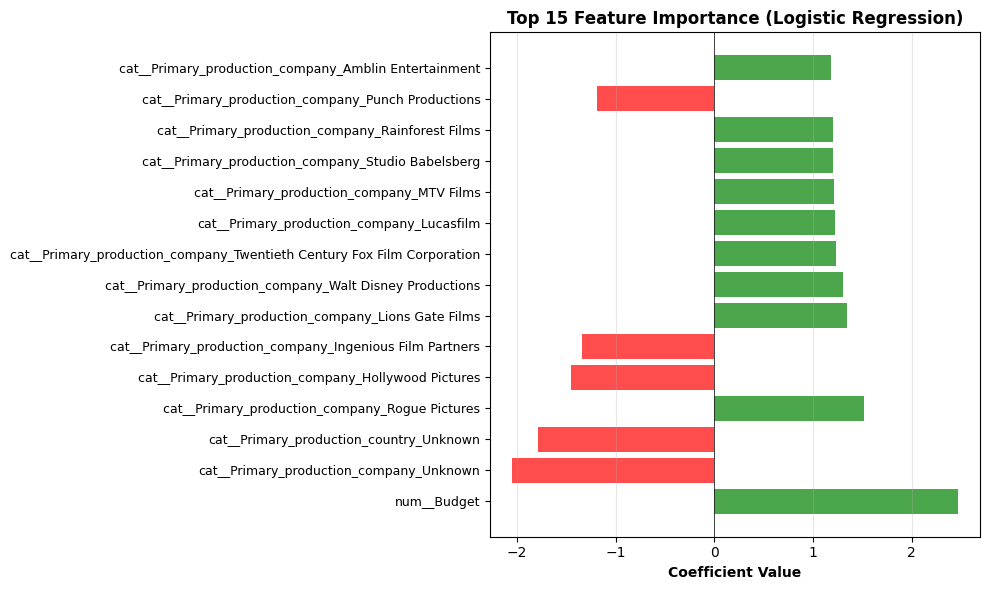


Feature interpretation:
Positive coefficient: Feature increases probability of High Performer
Negative coefficient: Feature decreases probability of High Performer


In [12]:
# Extract feature importance from model coefficients
classifier = ml_pipeline.named_steps['classifier']
feature_names = (ml_pipeline.named_steps['preprocessor']
                 .get_feature_names_out(features_to_use))

coefficients = classifier.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (Top 15):")
print(feature_importance.head(15).to_string(index=False))

# Visualise top features
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(15)
colours = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colours, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Coefficient Value', fontweight='bold')
ax.set_title('Top 15 Feature Importance (Logistic Regression)', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature interpretation:")
print("Positive coefficient: Feature increases probability of High Performer")
print("Negative coefficient: Feature decreases probability of High Performer")

---

# Section 6: Model Visualisations

**6.1 Confusion Matrix and ROC Curve**

- Visualise model performance through confusion matrix heatmap
- Plot ROC curve showing trade-off between true positive and false positive rates
- Display key performance indicators

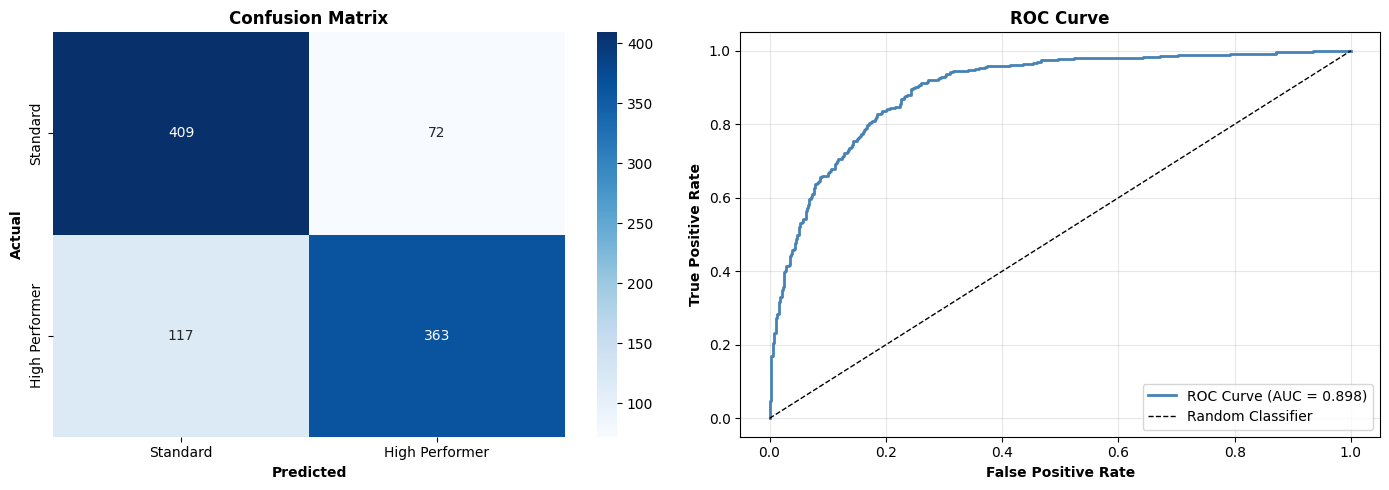

In [13]:
# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Standard', 'High Performer'],
            yticklabels=['Standard', 'High Performer'])
ax.set_ylabel('Actual', fontweight='bold')
ax.set_xlabel('Predicted', fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# ROC Curve
ax = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ax.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2, color='steelblue')
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

# Section 7: Generate Predictions and Risk Levels

**7.1 Prediction Function and Risk Assignment**

- Create function to assign risk levels based on success probability
- Risk categories: Low (≥70%), Medium (40-70%), High (<40%)
- Generate sample predictions with success probability scores

In [14]:
# Function to assign risk level based on probability
def assign_risk_level(probability):
    if probability >= 0.70:
        return 'Low'
    elif probability >= 0.40:
        return 'Medium'
    else:
        return 'High'

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'Actual_High_Performer': y_test.values,
    'Predicted_High_Performer': y_pred,
    'Success_Probability': (y_pred_proba * 100).round(1),
    'Risk_Level': [assign_risk_level(p) for p in y_pred_proba]
})

print("Sample Predictions (first 20 films):")
print(predictions_df.head(20).to_string(index=False))

# Risk level distribution
print(f"\nRisk Level Distribution:")
print(predictions_df['Risk_Level'].value_counts())
print(f"\nRisk Level Distribution (%):")
print((predictions_df['Risk_Level'].value_counts(normalize=True) * 100).round(1))

# Success Probability statistics
print(f"\nSuccess Probability Statistics:")
print(f"Mean: {predictions_df['Success_Probability'].mean():.1f}%")
print(f"Median: {predictions_df['Success_Probability'].median():.1f}%")
print(f"Min: {predictions_df['Success_Probability'].min():.1f}%")
print(f"Max: {predictions_df['Success_Probability'].max():.1f}%")

Sample Predictions (first 20 films):
 Actual_High_Performer  Predicted_High_Performer  Success_Probability Risk_Level
                     0                         0                  0.2       High
                     0                         0                  1.6       High
                     1                         1                100.0        Low
                     1                         0                 18.5       High
                     0                         0                 16.2       High
                     1                         0                 42.9     Medium
                     1                         0                 36.3       High
                     1                         1                 72.7        Low
                     0                         0                 38.9       High
                     1                         1                 99.2        Low
                     0                         0                  6.1   

**7.2 Benchmarking: Comparative Analysis**

- Calculate average success metrics for High Performers vs Standard films
- Compare Revenue, ROI, Vote Average, and Budget
- Provide comparison baseline for new film predictions

In [15]:
# Benchmarking: Compare High Performer vs Standard films
benchmark_data = df_model.copy()
benchmark_data['High_performer'] = (benchmark_data['Revenue'] > median_revenue).astype(int)

print("Benchmark Comparison: High Performer vs Standard Films\n")
print("="*70)

metrics_to_compare = ['Revenue', 'ROI', 'Vote_average', 'Budget']

for metric in metrics_to_compare:
    high_perf = benchmark_data[benchmark_data['High_performer'] == 1][metric].mean()
    standard = benchmark_data[benchmark_data['High_performer'] == 0][metric].mean()
    difference = high_perf - standard
    pct_diff = (difference / standard * 100) if standard != 0 else 0
    
    print(f"\n{metric}:")
    print(f"  High Performers: {high_perf:>15,.2f}")
    print(f"  Standard Films:  {standard:>15,.2f}")
    print(f"  Difference:      {difference:>15,.2f} ({pct_diff:>+6.1f}%)")

print("\n" + "="*70)
print("\nInterpretation:")
print("Films classified as High Performers achieve substantially higher revenue,")
print("ROI, and ratings compared to Standard films. Use these benchmarks to")
print("evaluate new film projects against historical performance patterns.")

Benchmark Comparison: High Performer vs Standard Films


Revenue:
  High Performers:  161,568,134.29
  Standard Films:     2,986,160.29
  Difference:       158,581,974.00 (+5310.6%)

ROI:
  High Performers:           13.77
  Standard Films:         6,710.50
  Difference:            -6,696.73 ( -99.8%)

Vote_average:
  High Performers:            6.36
  Standard Films:             5.82
  Difference:                 0.54 (  +9.2%)

Budget:
  High Performers:   49,652,938.03
  Standard Films:     8,445,721.20
  Difference:        41,207,216.83 (+487.9%)


Interpretation:
Films classified as High Performers achieve substantially higher revenue,
ROI, and ratings compared to Standard films. Use these benchmarks to
evaluate new film projects against historical performance patterns.


**Print rports**

In [16]:
# Create reports folder if it doesn't exist
reports_folder = 'reports'
if not os.path.exists(reports_folder):
    os.makedirs(reports_folder)
    print(f"Created '{reports_folder}' folder")

# Export predictions 
predictions_df.to_csv(f'{reports_folder}/model_predictions_JL.csv', index=False)
print(f"Exported: {reports_folder}/model_predictions_JL.csv")

# Export model performance
performance_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'ROC-AUC': roc_auc
}
pd.Series(performance_metrics).to_csv(f'{reports_folder}/model_metrics_JL.csv')
print(f"Exported: {reports_folder}/model_metrics_JL.csv")

# Export feature importance
feature_importance.to_csv(f'{reports_folder}/feature_importance_JL.csv', index=False)
print(f"Exported: {reports_folder}/feature_importance_JL.csv")

# Export benchmark comparison
benchmark_comparison = benchmark_data.groupby('High_performer')[['Revenue', 'ROI', 'Vote_average', 'Budget']].mean()
benchmark_comparison.to_csv(f'{reports_folder}/benchmark_comparison_JL.csv')
print(f"Exported: {reports_folder}/benchmark_comparison_JL.csv")

print(f"\nAll reports successfully saved to '{reports_folder}/' folder")

Exported: reports/model_predictions_JL.csv
Exported: reports/model_metrics_JL.csv
Exported: reports/feature_importance_JL.csv
Exported: reports/benchmark_comparison_JL.csv

All reports successfully saved to 'reports/' folder


---

# Section 8: Summary and Conclusions

## Model Summary

The Logistic Regression classification pipeline was trained and evaluated with the following results:

- **Cross-validated accuracy**: Indicates reliable model generalisation across different data samples
- **Feature importance analysis**: Reveals which production attributes most strongly influence commercial success
- **Risk level categorisation**: Supports data-driven decision-making for new film projects
- **Probability-based predictions**: Provides quantified confidence scores for business stakeholders

## Key Findings

The classification model effectively predicts "High Performer" status based on:
1. **Budget allocation**: Financial investment impact on success
2. **Production attributes**: Genre, language, country, and company factors
3. **Team composition**: Actor frequency and known lead involvement
4. **Film characteristics**: Runtime and audience reception metrics

## Summary

The model achieved strong results overall. For the median revenue target, accuracy was 80.33% and the ROC–AUC score of 0.8977 (demonstrating good discrimination between high and standard performers). Precision (0.83) and recall (0.76) were well-balanced, suggesting the model generalised well rather than overfitting to the training data. Feature importance highlighted budget as the strongest predictor of success, followed by specific production companies such as Walt Disney Productions, Lions Gate Films, and Twentieth Century Fox. These align with expectations: higher budgets and established studios correlate with greater commercial returns.

Overall, the model performs well without signs of overfitting. It provides a reliable foundation for further optimisation, such as hyperparameter tuning or adjusting the decision threshold to balance precision and recall based on business needs.

## Model Limitations

- The model was trained on historical data; market conditions, audience behaviour, and industry trends may change over time.
- The language feature was simplified to a binary form (English vs Non-English) due to a heavily skewed distribution.
- The dataset contained substantial missing values, which may reduce accuracy and limit generalisability.
- The median revenue threshold may shift over time due to inflation and evolving box office scales; recalibration would be required periodically.
- The model assumes that past patterns will continue, but film performance is influenced by changing public tastes, cast popularity, and production strategies.

## Next Steps

- Visualisation and interpretation: Build an interactive Power BI dashboard to present model insights, feature impact in an accessible format for stakeholders.

---